In [184]:
import sys
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


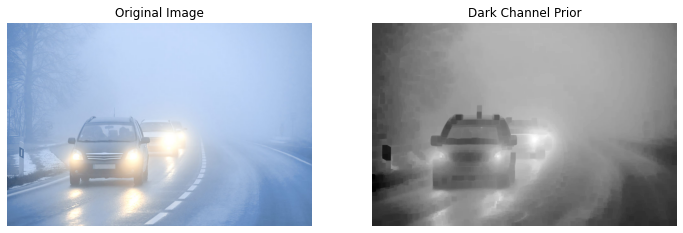

In [185]:
# Dark Channel Prior Function
# Parameters: Image and the structural element
# Returns: Dark Channel Prior Image
def DarkChannelPrior(img, se):
    # Split the image into its channels
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    # Get the minimum of the channels
    min_channel = np.minimum(np.minimum(r, g), b)
    # Create a structural element
    structural_element = np.ones((se, se), np.uint8)
    # Get the minimum of the image
    darkChannel = erosion(min_channel, structural_element)
    return darkChannel

img = io.imread('Fog removal testcases/img-foggy-weather-960x.jpg')
se = 15
darkChannel = DarkChannelPrior(img, se)
show_images([img, darkChannel], ['Original Image', 'Dark Channel Prior'])

In [186]:
# Atmospheric Light Estimation Function
# Parameters: Dark Channel Prior Image and Original Image
# Returns: Atmospheric Light: which is the average of the brightest pixels
def AtmosphericLightEstimation(darkChannel, img):
    # Get the size of the image
    size = img.shape[0] * img.shape[1]
    # We are going to pick the top 0.1% brightest pixels in the dark channel according to the research paper
    # I maxed between 1 and the number of pixels in the dark channel because the minimum number of pixels in an image is 1
    totalBrightestPixels = int(max(math.floor(size * 0.001), 1))
    # Reshape the dark channel into a 1D array to be sorted
    darkReshaped = darkChannel.reshape(1, size)
    # We are going to sort the dark channel ascendingly , but return the corresponding indices instead of the values
    darkChannelIndices = darkReshaped.argsort()
    # Reshaped the dark channel indices again for easy slicing (when taking only the brightest pixels)
    darkChannelIndicesReshaped = darkChannelIndices.reshape(size, 1)
    # Get the brightest pixels in the dark channel
    # We are going to take the last 0.1% brightest pixels
    brightestPixels = darkChannelIndicesReshaped[- totalBrightestPixels : :]
    # Reshape the image into a matrix to be used in getting the original RGB values of the brightest pixels
    # It is as if each row is a pixel and each column is a channel
    imgReshaped = img.reshape(size, 3)
    # Get the original RGB values of the brightest pixels
    # We are going to calculate the average of the brightest pixels
    brightestPixelsRGB = imgReshaped[brightestPixels]
    # Get the average of the brightest pixels
    atmosphericLight = np.mean(brightestPixelsRGB, axis=0)
    return atmosphericLight

atmosphericLight = AtmosphericLightEstimation(darkChannel, img)
print(atmosphericLight)

[[254.99511401 254.98534202 254.69218241]]


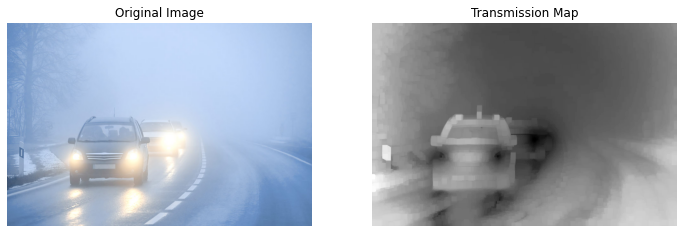

In [187]:
# Transmission Estimation Function
# Parameters: Original Image, Atmospheric Light and the structural element
# Returns: Transmission Image
# Transmission is an estimate of how much of the light from the original object is making it through the fog at each pixel.
def TransmissionEstimation(img, atmosphericLight, se):
    # If we remove the fog thoroughly, the image may seem unnatural and we may lose the feeling of depth. 
    # So, we can optionally keep a very small amount of fog for the distant objects by introducing a constant parameter w (0≤ w ≤1)
    w = 0.95
    image = np.zeros(img.shape)
    # Normalize each channel in the image by Atmospheric Light
    for ind in range(0,3):
        image[:,:,ind] = (img[:,:,ind] / (atmosphericLight[0][ind]))
    # Get the dark channel prior of the transmission map and apply the equation:
    # t = 1 - w * DarkChannelPrior(t)
    # Transmission essentially will look opposite to the dark channel picture.
    transmission_map = 1 - w * DarkChannelPrior(image, se)
    return transmission_map

transmission_map = TransmissionEstimation(img, atmosphericLight, se)
show_images([img, transmission_map], ['Original Image', 'Transmission Map'])


In [188]:
# Bilateral Filter Function
# A bilateral filter is a non-linear, edge-preserving, and noise-reducing smoothing filter for images.  Slow Performance
# It replaces the intensity of each pixel with a weighted average of intensity values from nearby pixels.
# Consider a pixel located at (i,j) that needs to be denoised in image using its neighbouring pixels 
# and one of its neighbouring pixels is located at (k, l)
# Parameters: i, j, img, sigma_d, sigma_r
# i, j = coordinates of the pixel, img = image
# sigma_d and sigma_r are smoothing parameters   
def BilateralPixel(image, i, j, sigma_d, sigma_r):    
    denomenator = 0
    numerator = 0
    # Loop through the neighbouring pixels and calculate their average
    for k in range(i-1, i+2):
        for l in range(j-1, j+2):
            # Get the distance between the pixel at (k, l) and the pixel at (i, j) and divide it by sigma_d^2 (according to the equation)
            term1 = np.exp(-((k - i) ** 2 + (l - j) ** 2) / sigma_d ** 2)
            # Get the intensity of the pixel at (k, l) and the pixel at (i, j)
            i1 = image[k, l]
            i2 = image[i, j] 
            # Get the difference between the intensity of the pixel at (k, l) and the pixel at (i, j) and divide it by sigma_r^2 (according to the equation)
            term2 = np.exp(-((i1 - i2)** 2) / sigma_r ** 2)
            denomenator += term1 * term2
            numerator += term1 * term2 * image[k, l]
    # Get the denoised pixel value
    Id = numerator / denomenator
    return Id

def BilateralFilter(image, sigma_d, sigma_r):
    filtered_image = np.zeros(image.shape)
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            filtered_image[i, j] = BilateralPixel(image, i, j, sigma_d, sigma_r)
    return filtered_image

# Guided Filter Function
# Parameters: Image, p, r, Epsilon
# p = Transmission Map, r = 60 (size of filter), Epsilon = 0.0001 (from research paper)
# Returns: Guided Filter Image
# The guided filter uses a local linear model as an edge-preserving filter.
# Faster than the bilateral filter.
# Used averaging filter using open cv rather than skimage because it is faster, skimage took over 1 minute to run this cell
# while open cv took less than 1 second
def GuidedFilter(img, p, r, eps):
    # Get the mean of the image and the transmission map
    meanI = cv2.boxFilter(img, cv2.CV_64F, (r, r))
    meanP = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    # Get the mean of the image and the transmission map multiplied together
    meanIp = cv2.boxFilter(img * p, cv2.CV_64F, (r, r))
    # Get the mean of the image squared
    meanII = cv2.boxFilter(img * img, cv2.CV_64F, (r, r))
    # Get the variance of the image
    varI = meanII - meanI * meanI
    # Get the covariance of the image and the transmission map
    covIp = meanIp - meanI * meanP
    # Get the a and b values
    a = covIp / (varI + eps)
    b = meanP - a * meanI
    # Get the mean of a and b
    meanA = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    meanB = cv2.boxFilter(b, cv2.CV_64F, (r, r))
    # Final result after applying the guided filter
    q = meanA * img + meanB
    return q

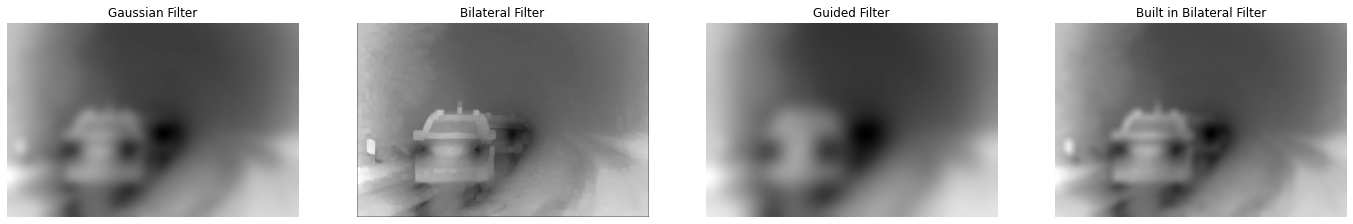

In [189]:
# Soft Matting Function
# We refine the transmission map by reducing the halos and block artifacts using soft matting
# Parameters: Original Image, Transmission Map
# Returns: Refined Transmission Map
def SoftMatting(img, transmission_map, filter_type):
    # Convert the image to grayscale
    img_gray = rgb2gray(img)
    # Normalize the image
    img_gray = np.float64(img_gray) / 255
    refined_img_bilateral = np.zeros(img_gray.shape)
    
    # Next, we are going to use 3 different types of filters: Gaussian, Bilateral and Guided Filters
    # We are going to use the Gaussian filter to smooth the transmission map, sigma = 15 after trial and error 
    if filter_type == 'Gaussian':
        refined_img = gaussian(transmission_map, 15)
    
    # We are going to use the Bilateral filter to smooth the image
    if filter_type == 'Bilateral':
        refined_img = BilateralFilter(transmission_map, sigma_d=200, sigma_r=200)
    
    # We are going to use the Guided filter to smooth the image
    if filter_type == 'Guided':
        refined_img = GuidedFilter(img_gray, transmission_map, 60, 0.0001)
    
    # We are going to use the built in bilateral filter to smooth the image
    if filter_type == 'Built in Bilateral':
        refined_img = cv2.bilateralFilter(transmission_map.astype(np.float32), 30, 200, 200)

    return refined_img

refined_img_gaussian = SoftMatting(img, transmission_map,'Gaussian')
refined_img_bilateral = SoftMatting(img, transmission_map,'Bilateral')
refined_img_guided = SoftMatting(img, transmission_map,'Guided')
refined_img_built_in_bilateral = SoftMatting(img, transmission_map,'Built in Bilateral')
show_images([refined_img_gaussian, refined_img_bilateral, refined_img_guided, refined_img_built_in_bilateral], ['Gaussian Filter', 'Bilateral Filter', 'Guided Filter', 'Built in Bilateral Filter'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


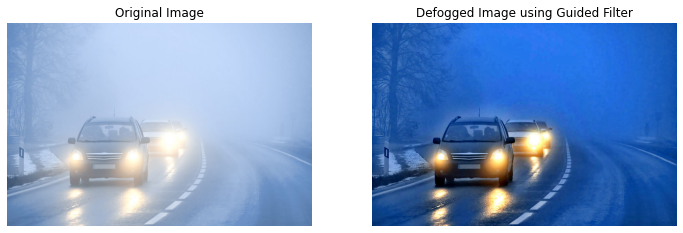

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


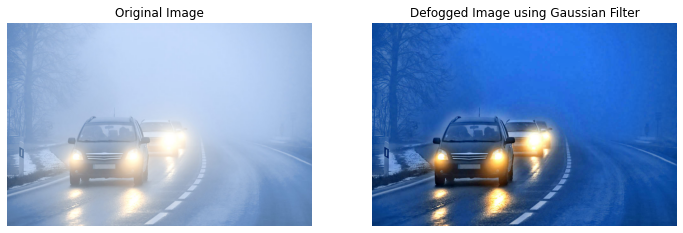

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


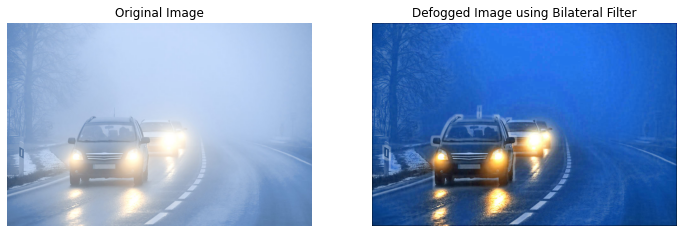

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


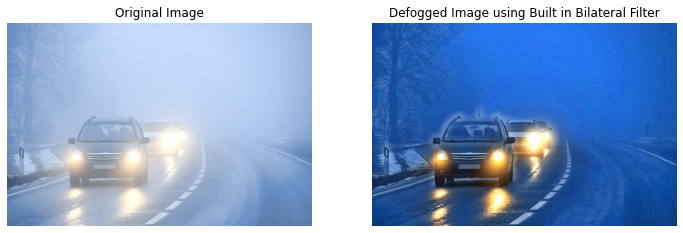

In [190]:
# Recovering the Scene Radiance Function
# Parameters: Original Image, Atmospheric Light, Refined Transmission Map, t0
# Returns: Recovered Scene Radiance
def RecoverSceneRadiance(img, atmosphericLight, refined_img, t0):
    # We are going to use the equation:
    # J = (I - A) / max(t, t0) + A
    # Where J is the recovered scene radiance, I is the original image, A is the atmospheric light, 
    # t is the refined transmission map and t0 is a small constant, like a lower bound for the transmission map
    recovered_img = np.zeros(img.shape, dtype=np.int64)
    # Get max of the refined transmission map and t0
    max_t = np.maximum(refined_img, t0)
    # Normalize each channel in the image by Atmospheric Light
    for index in range(0,3):
        recovered_img[:,:,index] = ((img[:,:,index] - atmosphericLight[0][index]) / max_t) + atmosphericLight[0][index]
    
    return recovered_img

defogged_img_guided = RecoverSceneRadiance(img, atmosphericLight, refined_img_guided, t0 = 0.1)
show_images([img, defogged_img_guided], ['Original Image', 'Defogged Image using Guided Filter'])
# This method is not good for image restoration due to the information loss in the edge region.
# As the filter size increases, the images get more blurred and at the same time edges also get smoothened
defogged_img_gaussian = RecoverSceneRadiance(img, atmosphericLight, refined_img_gaussian, t0 = 0.25)
show_images([img, defogged_img_gaussian], ['Original Image', 'Defogged Image using Gaussian Filter']) 
defogged_img_bilateral = RecoverSceneRadiance(img, atmosphericLight, refined_img_bilateral, t0 = 0.25)
show_images([img, defogged_img_bilateral], ['Original Image', 'Defogged Image using Bilateral Filter'])
defogged_img_built_in_bilateral = RecoverSceneRadiance(img, atmosphericLight, refined_img_built_in_bilateral, t0 = 0.25)
show_images([img, defogged_img_built_in_bilateral], ['Original Image', 'Defogged Image using Built in Bilateral Filter'])